In [17]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
import os
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import Image
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [18]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
batch_size = 100
epochs = 200
sample_size = 64
nz = 28*28
k = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# from torchvision.transforms.func/tional import to_pil_image
class GaussianNoise(object):
  def __init__(self,std,mean):
    self.std = std
    self.mean = mean
  def __call__(self,tensor):
    return (tensor + torch.randn(tensor.size())*self.std + self.mean)

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    transforms.Resize(64),
    GaussianNoise(mean=0.5,std=0.01),
    
])
to_pil_image = transforms.ToPILImage()


In [20]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

Feature batch shape: torch.Size([100, 1, 64, 64])
Labels batch shape: torch.Size([100])


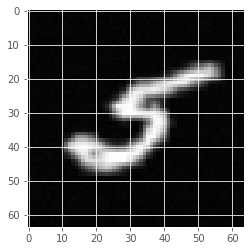

Label: 5


In [21]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
# print(img)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [22]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5

In [23]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(Z_DIM,G_HIDDEN*8,4,1,0,bias=False),
        nn.BatchNorm2d(G_HIDDEN*8),
        nn.ReLU(True),

        # 1st hidden layer
        nn.ConvTranspose2d(G_HIDDEN*8,G_HIDDEN*4,4,2,1,bias=False),
        nn.BatchNorm2d(G_HIDDEN*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(G_HIDDEN*4,G_HIDDEN*2,4,2,1,bias=False),
        nn.BatchNorm2d(G_HIDDEN*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(G_HIDDEN*2,G_HIDDEN,4,2,1,bias=False),
        nn.BatchNorm2d(G_HIDDEN),
        nn.ReLU(True),

        nn.ConvTranspose2d(G_HIDDEN,IMAGE_CHANNEL,4,2,1,bias=False),
        nn.Tanh()


    )

  def forward(self,input):
        return self.main(input)
    

In [24]:
# from numpy.ma.core import squeeze
class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator,self).__init__()
      self.main = nn.Sequential(
          nn.Conv2d(IMAGE_CHANNEL,D_HIDDEN,4,2,1,bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          #2nd layer
          nn.Conv2d(D_HIDDEN,D_HIDDEN*2,4,2,1,bias=False),
          nn.BatchNorm2d(D_HIDDEN*2),
          nn.LeakyReLU(0.2,inplace=True),

          nn.Conv2d(D_HIDDEN*2,D_HIDDEN*4,4,2,1,bias=False),
          nn.BatchNorm2d(D_HIDDEN*4),
          nn.LeakyReLU(0.2,inplace=True),


          nn.Conv2d(D_HIDDEN*4,D_HIDDEN*8,4,2,1,bias=False),
          nn.BatchNorm2d(D_HIDDEN*8),
          nn.LeakyReLU(0.2,inplace=True),

          nn.Conv2d(D_HIDDEN*8,1,4,1,0,bias=False),
          nn.Sigmoid()      
      )
  def forward(self,input):
    return self.main(input).view(-1,1).squeeze(1)

In [25]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [26]:
generator = Generator().to(device)
# generator.apply(weights_init)
discriminator = Discriminator().to(device)
# discriminator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [27]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002,betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002,betas=(0.5, 0.999))
criterion = nn.BCELoss()
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] #

In [28]:
def label_real(size):
    data = torch.ones(size)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size)
    return data.to(device)

def create_noise(sample_size,nz):
  return torch.randn(batch_size,nz,1,1).to(device)

def save_generator_image(image,path):
  save_image(image,path)

In [29]:
def train_discriminator(optimizer, data_real,data_fake):
  b_size = data_real.size(0)
  real_label = label_real(b_size)
  fake_label = label_fake(b_size)
  optimizer.zero_grad()
  output_real = discriminator(data_real)
  output_fake = discriminator(data_fake)
  loss_real = F.binary_cross_entropy(real_label,output_real)
  loss_fake = F.binary_cross_entropy(fake_label,output_fake)
  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real + loss_fake

def train_generator(optimizer,data_fake):
  b_size = data_fake.size(0)
  real_label = label_real(b_size)
  optimizer.zero_grad()
  output = generator(data_fake)
  loss = criterion(real_label,output)
  loss.backward()
  optimizer.step()
  return loss
  

In [30]:
from IPython.display import clear_output
def plot_all_losses(d_loss_run, g_loss_run):
    plt.plot(d_loss_run, label = "D-loss")

    plt.plot(g_loss_run, label = "G-loss")
    plt.legend()
    plt.show()

def show_gen_sample(z,G):
    print(G(z)[0].shape)
    samples = G(z)[0]
    samples = samples.view([64,64])
    sample = samples.detach().cpu().numpy()
    plt.imshow(sample, cmap = "gray")
    plt.show()

def wasserstein_loss(y_true, y_pred):
   return torch.mean(y_true * y_pred)

In [31]:
sample_vectors = torch.randn(batch_size,Z_DIM,1,1).to(device)
def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=10)
    Image(os.path.join(sample_dir, 'fake_images-{0:0=4d}.png'.format(index)))

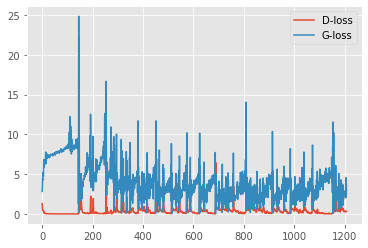

  2%|▏         | 9/600 [00:03<04:22,  2.25it/s]

Saving fake_images-1208.png
3


  2%|▏         | 9/600 [00:04<04:37,  2.13it/s]


KeyboardInterrupt: ignored

In [32]:
g_loss_run=[]
d_loss_run = []

i = 0
for epoch in range(5):
  for data in tqdm(train_loader):
    print(epoch + 1)
    x, _ = data
    # print(x.data[0])
    # plt.show(x.data[0])
    siz = x.size(0)
    x = x.to(device)
    # print(siz)
    # x = x.view(x.size(0),-1)
    discriminator.zero_grad()
    one_labels = label_real(siz)
    zeroes_labels = label_fake(siz)
    z = create_noise(siz,Z_DIM)
    
    # print(d_fake)
    d_real = discriminator(x).view(-1)
    # print(d_fake)
    # w_d_fake_loss = wasserstein_loss(zeroes_labels,d_fake)
    # w_d_real_loss = wasserstein_loss(one_labels,d_real)
    
    Dreal_loss = F.binary_cross_entropy(d_real,one_labels)
    Dreal_loss.backward() 
    
    
    # d_loss.backward()
    
    g_sample = generator(z)
    # print(g_sample)
    d_fake = discriminator(g_sample).view(-1)
    Dfake_loss = F.binary_cross_entropy(d_fake,zeroes_labels) 
    Dfake_loss.backward()
    d_loss = Dfake_loss + Dreal_loss
    optim_d.step()
    
    generator.zero_grad()
    z = create_noise(siz,Z_DIM)
    g_sample = generator(z)
    d_fake = discriminator(g_sample).view(-1)
    # w_d_fake = wasserstein_loss(one_labels,d_fake)
    D_loss = F.binary_cross_entropy(d_fake,one_labels)
    
    D_loss.backward()
    optim_g.step()
    # g_loss = D_loss

    g_loss_run.append(D_loss.detach().cpu().numpy())
    d_loss_run.append(d_loss.detach().cpu().numpy())
  

    clear_output(wait = True)
    plot_all_losses(d_loss_run, g_loss_run)
    # show_gen_sample(z,generator)
    save_fake_images(i)
    i += 1




In [ ]:
from IPython.display import Image
from torchvision.utils import save_image
for images,_ in tqdm(train_loader):
  images = images.reshape(images.size(0),1,64,64)
  save_image(images, os.path.join(sample_dir, 'real_images.png'), nrow=10)
Image(os.path.join(sample_dir,'real_images.png'))

In [ ]:

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [35]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("GAN_mnist.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
make_gif("samples")